In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, classification_report

torch.manual_seed(42)
np.random.seed(42)

In [152]:
df = pd.read_csv('mnist_10000.csv')
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


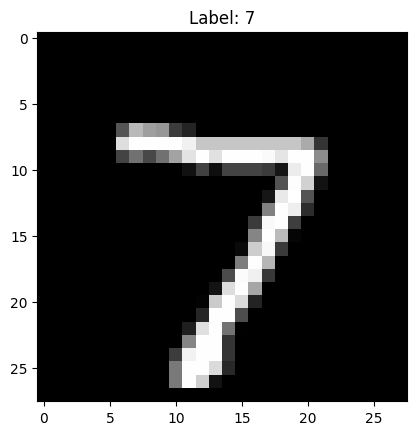

In [153]:
x = df.drop('label', axis=1).values
y = df['label'].values

image = x[0].reshape(28, 28)
plt.imshow(image, cmap='gray')
plt.title(f'Label: {y[0]}')
plt.show()

In [154]:
class MNISTDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x) / 255.0
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = MNISTDataset(x, y)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train size: {len(train_dataset)}, Test size: {len(test_dataset)}')


Train size: 7000, Test size: 3000


In [155]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=128,hidden_size2=64, output_size=10):
        super(MLP,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, output_size)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)

print("device:", device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

device: cuda
MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
Total parameters: 109386


In [156]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr = learning rate


In [157]:
n_epochs = 11

model.train()
loss_history = []
for epoch in range(n_epochs):
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        outputs = model(features)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}')


Epoch [1/11], Loss: 0.0147
Epoch [2/11], Loss: 0.0053
Epoch [3/11], Loss: 0.0041
Epoch [4/11], Loss: 0.0033
Epoch [5/11], Loss: 0.0028
Epoch [6/11], Loss: 0.0022
Epoch [7/11], Loss: 0.0019
Epoch [8/11], Loss: 0.0016
Epoch [9/11], Loss: 0.0013
Epoch [10/11], Loss: 0.0011
Epoch [11/11], Loss: 0.0009


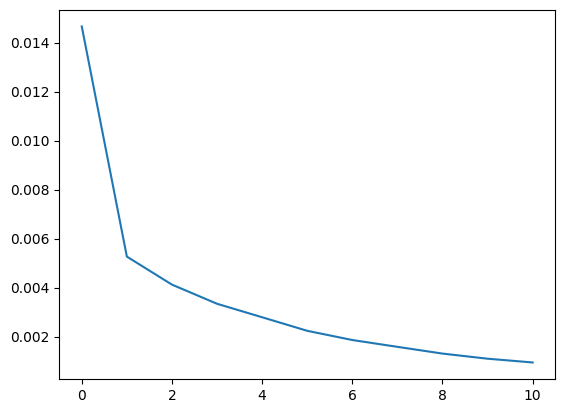

In [158]:
plt.plot(loss_history)

In [159]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 94.43%


              precision    recall  f1-score   support

           0       0.94      0.99      0.97       270
           1       0.98      0.98      0.98       318
           2       0.93      0.92      0.92       308
           3       0.93      0.95      0.94       302
           4       0.94      0.96      0.95       300
           5       0.93      0.89      0.91       263
           6       0.96      0.95      0.95       279
           7       0.93      0.96      0.95       331
           8       0.93      0.93      0.93       307
           9       0.96      0.90      0.93       322

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



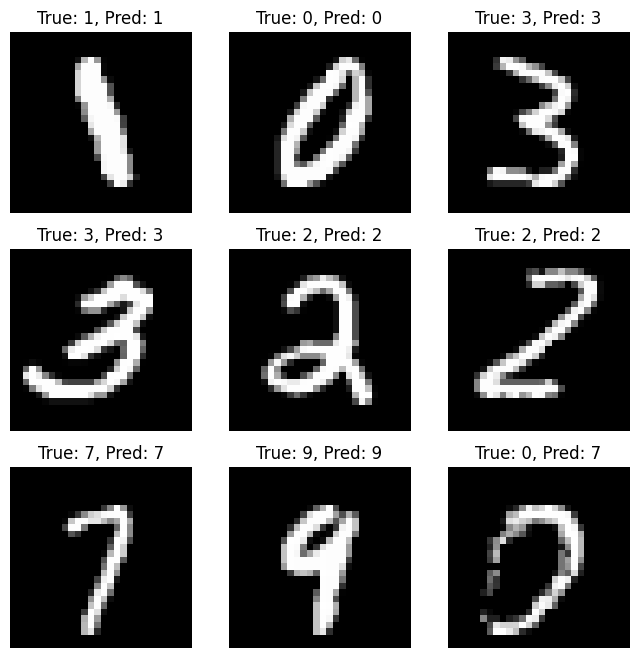

In [160]:
#visualize some predictions
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    if i < len(test_dataset):
        image, label = test_dataset[i]
        image_reshaped = image.numpy().reshape(28, 28)
        ax.imshow(image_reshaped, cmap='gray')
        ax.set_title(f'True: {label}, Pred: {all_preds[i]}')
        ax.axis('off')
print(classification_report(all_labels, all_preds))
plt.show()
